In [1]:
import os
import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

cwd = os.getcwd()
model_path = os.path.abspath(os.path.join(cwd, os.pardir, 'models'))
sys.path.append(model_path)
from diamond_ODE_model import *

In [ ]:
# Load model
model = diamondODEModel()

# Define model parameters
times = np.linspace(0, 31, 500)
n_simulations = 10000
inferred_parameters = pd.read_csv('../data/inferred_parameters.csv')

# Load symptomatic case data
data = pd.read_csv('../data/data_cases_symp.csv')
data['onset_date'] = pd.to_datetime(data['onset_date'], format='%d-%b')
all_simulated_values = []

# Sample parameters and simulate
for _ in range(n_simulations):
    idx = np.random.randint(0, inferred_parameters.shape[0])
    selected_params = inferred_parameters.iloc[idx].to_list()
    values = model.simulate(selected_params[:8], times)
    
    values[:,0] += np.random.normal(0, selected_params[-2], size=len(values))
    values[:,1] += np.random.normal(0, selected_params[-1], size=len(values))
    
    all_simulated_values.append(values)

/Users/georgebooth/Documents/ClosedPopulations/cruiseship/models/diamond_ODE_model.py:61: RuntimeWarning: overflow encountered in exp
  bcp = (bbarcp + a2) * ccp * (1 - b1 / (1 + np.exp(-b2 * (t - tcp - a))))
/Users/georgebooth/Documents/ClosedPopulations/cruiseship/models/diamond_ODE_model.py:62: RuntimeWarning: overflow encountered in exp
  bcc = (bbarcc + a2) * ccc * (1 - b1 / (1 + np.exp(-b2 * (t - tcc - a))))
/Users/georgebooth/Documents/ClosedPopulations/cruiseship/models/diamond_ODE_model.py:63: RuntimeWarning: overflow encountered in exp
  bpc = (bbarpc + a2) * cpc * (1 - b1 / (1 + np.exp(-b2 * (t - tpc - a))))
/Users/georgebooth/Documents/ClosedPopulations/cruiseship/models/diamond_ODE_model.py:64: RuntimeWarning: overflow encountered in exp
  bpp = (bbarpp + a2) * cpp * (1 - b1 / (1 + np.exp(-b2 * (t - tpp - a))))


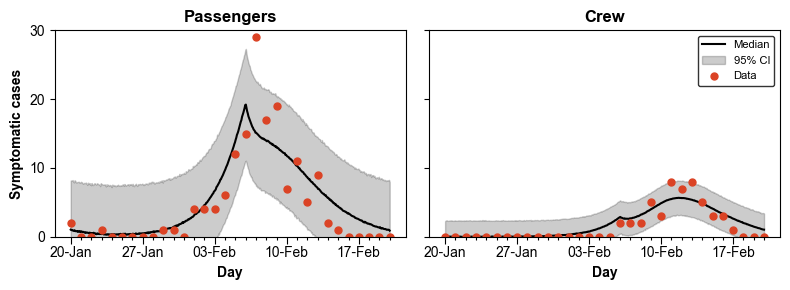

In [ ]:
# Convert all_simulated_values to a 3D NumPy array
all_simulated_values_array = np.array(all_simulated_values)

# Define datapoint colour
red = '#DB4325'

# Calculate median, 2.5th, and 97.5th percentiles for passengers (column 0) and crew (column 1) over time
median_passengers = np.median(all_simulated_values_array[:,:,0], axis=0)
lower_percentile_passengers = np.percentile(all_simulated_values_array[:,:,0], 2.5, axis=0)
upper_percentile_passengers = np.percentile(all_simulated_values_array[:,:,0], 97.5, axis=0)

median_crew = np.median(all_simulated_values_array[:,:,1], axis=0)
lower_percentile_crew = np.percentile(all_simulated_values_array[:,:,1], 2.5, axis=0)
upper_percentile_crew = np.percentile(all_simulated_values_array[:,:,1], 97.5, axis=0)

plt.rcParams['font.family'] = 'Arial'
# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plotting for passengers
axs[0].plot(times, median_passengers, label='Median Passengers', color='black')
axs[0].fill_between(times, lower_percentile_passengers, upper_percentile_passengers, color='black', alpha=0.2, label='5th to 95th Percentile Passengers')
axs[0].plot(data.index, data['pass'], 'o', label='Actual Passengers', color=red, markersize=5)
axs[0].plot()
axs[0].set_title('Passengers', weight='bold')
axs[0].set_xlabel('Day', weight='bold')
axs[0].set_ylabel('Symptomatic cases', weight='bold')
axs[0].set_ylim(0, 30)

# Plotting for crew
axs[1].plot(times, median_crew, label='Median', color='black')
axs[1].fill_between(times, lower_percentile_crew, upper_percentile_crew, color='black', alpha=0.2, label='95% CI')
axs[1].plot(data.index, data['crew'], 'o', label='Data', color=red, markersize=5)
axs[1].set_title('Crew', weight='bold')
axs[1].set_xlabel('Day', weight='bold')
axs[1].legend(edgecolor='black', fontsize=8)
axs[1].set_ylim(0, 30)

# Figure formatting
full_indices = data.index
full_dates=data['onset_date'].dt.strftime('%d-%b')
label_interval=7
labels=['' if (i % label_interval != 0) else date for i, date in enumerate(full_dates)]

for ax in axs:
    ax.set_xticks(full_indices)
    ax.set_xticklabels(labels)
    ax.set_yticks([0, 10, 20, 30])
    for i, tick in enumerate (ax.xaxis.get_major_ticks()):
        size = 5 if i % label_interval == 0 else 2
        tick.tick1line.set_markersize(size)
        tick.tick2line.set_markersize(size)

plt.tight_layout()
plt.show()